In [1]:
# Explore biosphric fluxes
# 1, net terrestrial exchange, from GEOS-Chem
# 2, balanced ecosystem uptake (near neutral), from GEOS-Chem
# 3, CASA 2016 ecosystem exchange, by Liang
# 4, compare them, annual total and seasonality
# 5, output CASA to match the format of GEOS-Chem

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from util.functions import area_latlon # grid area in km^2
from util.gamap_colormap import WhGrYlRd

In [4]:
# Terrestrial, GEOS-Chem default
input_dir = '/geos/d21/GC_DATA/ExtData/HEMCO/'
fname = 'CO2/v2015-04/BIO/Net_terrestrial_exch_5.29Pg.generic.1x1.nc'
ds_ter  = xr.open_dataset(input_dir+fname)

# year 2000, annual mean
lat_res = ds_ter.attrs['Delta_Lat']
lon_res = ds_ter.attrs['Delta_Lon']
varname = 'CO2'
unit    = ds_ter[varname].attrs['units']
#ds_ter['CO2']

In [5]:
dr_gc = ds_ter[varname][0,:,:].copy()

In [6]:
# sum up global total
for ilat, lat in enumerate(dr_gc.lat):
    area_tmp = area_latlon(lat1 = lat, 
                            lon1 = dr_gc.lon[10].values, 
                            lat2 = lat + lat_res, 
                            lon2 = dr_gc.lon[10].values + lon_res)
    dr_gc[ilat,:] = dr_gc[ilat,:] * area_tmp *3600*24*366*1e6 # unit: kgCO2/yr
gc_total_original = dr_gc.copy() # plot later, kgCO2/yr/grid cell
total = dr_gc.sum()              # kgCO2/year, same as data description
ann_total = total.values         # kg/yr
ann_total_C_original = total.values*1e-12*12/44  # GtC/yr
    
print('annual total from this calculation:')
print(' ',ann_total_C_original)
print(' ')

annual total from this calculation:
  -5.269060654917819
 


In [7]:
#  CASA 3 hourly, by Liang
input_dir = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/'
fname     = 'NEE.3hrly.1x1.25.2016.nc'
ds_liang  = xr.open_dataset(input_dir+fname)

lat_res = 1.
lon_res = 1.25
varname = 'NEE'

dr_liang = ds_liang[varname].copy()

In [8]:
for ilat, lat in enumerate(dr_liang.lat):
    area_tmp = area_latlon(lat1 = lat, 
                           lon1 = dr_liang.lon[10].values, 
                           lat2 = lat + lat_res, 
                           lon2 = dr_liang.lon[10].values + lon_res)
    dr_liang[:,ilat,:] = dr_liang[:,ilat,:]*area_tmp*3600*3*1e6 # unit: kgCO2/yr
gc_total_liang = dr_liang.sum(dim = 't-3hr')   # plot later
annual_total = gc_total_liang.sum()
ann_total_C_liang = annual_total.values*1e-12*12/44  # GtC/yr

print('annual total from this calculation:')
print(' ', ann_total_C_liang)
print(' ')

annual total from this calculation:
  -0.5014272916014545
 


In [9]:
# Biosphere, SiB3 balanced Net Ecosystem Production (NEP) CO2
input_dir = '/geos/d21/GC_DATA/ExtData/HEMCO/'
fname = 'CO2/v2015-04/BIO/SiB3_3hr_NEP.nc'
ds_bio  = xr.open_dataset(input_dir+fname)
# year range: 2006 - 2010, get 2010 for this calculation
lat_res = ds_bio.attrs['Delta_Lat']
lon_res = ds_bio.attrs['Delta_Lon']
varname = 'CO2'
unit    = ds_bio[varname].attrs['units']
#ds_bio

In [10]:
# selection a year of data
begin = 4*8*365 + 8 # 2010, last year available
end = 5*8*365 + 8
data = ds_bio[varname][begin:end,:,:].copy()
np.shape(data)

(2920, 181, 288)

In [11]:
# calculate global total emission
#area_lat = np.zeros(len(data.lat))
for ilat, lat in enumerate(data.lat):
    area_tmp = area_latlon(lat1 = lat, 
                            lon1 = data.lon[10].values, 
                            lat2 = lat + lat_res, 
                            lon2 = data.lon[10].values + lon_res)
    #area_lat[ilat] = area_tmp.values
    data[:,ilat,:] = data[:,ilat,:]*area_tmp*3*3600*1e6 # unit: kgCO2/3hours
gc_total_sib = data.sum(dim = 'time')          # kgCO2/year, same as data description
annual_total = gc_total_sib.sum()
ann_total_sib = annual_total.values*1e-12*12/44 # GtC/yr
#plt.plot(data.lat, area_lat)   
print('annual total from this calculation (GtC/yr):')
print(ann_total_sib)

annual total from this calculation (GtC/yr):
-0.060708582493090905


NameError: name 'output_dir' is not defined

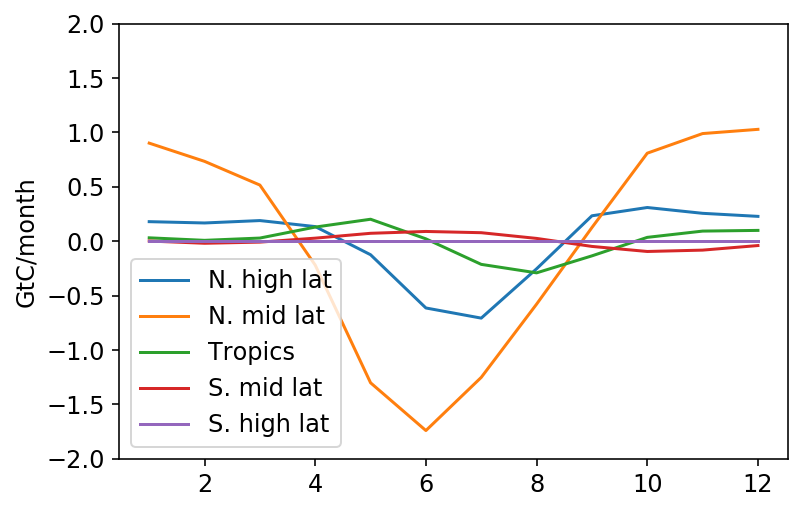

In [12]:
# SIB seasonal cycles
months = np.arange('2010-01', '2011-02', dtype='datetime64[M]')
nh = []
nm = []
tr = [] 
sm = []  
sh = []

for i in range(12):
    nh.append(data.sel(lat = slice(60,90), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    nm.append(data.sel(lat = slice(30,60), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    tr.append(data.sel(lat = slice(-30,30), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    sm.append(data.sel(lat = slice(-60,-30), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    sh.append(data.sel(lat = slice(-90,-60), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)

sib_season = [nh,nm,tr,sm,sh]
lab = ['N. high lat', 'N. mid lat', 'Tropics', 'S. mid lat', 'S. high lat']
fig = plt.figure(figsize=[6, 4])
for i in range(5):
    plt.plot(range(1,13), sib_season[i], label = lab[i])
plt.ylabel('GtC/month')
plt.ylim(-2,2)
plt.legend()

fig.savefig(output_dir + '/seasonal_sib.png', dpi = 300)

In [ ]:
# ODIAC
input_dir = '/exports/csce/datastore/geos/users/msadiq/'
lat_res = 1.
lon_res = 1.
varname1 = 'land'
varname2 = 'intl_bunker'

In [ ]:
ds_odiac = xr.open_dataset(input_dir+'odiac/odiac2019_1x1d_2016.nc')
#ds_odiac['land']

In [ ]:

dr_odiac = ds_odiac[varname1] + ds_odiac[varname2]
days_in_month = [31,29,31,30,31,30,31,31,30,31,30,31]

for ilat, lat in enumerate(dr_odiac.lat):
    for imonth in range(12):
        area_tmp = area_latlon(lat1 = lat, 
                                lon1 = dr_odiac.lon[10].values, 
                                lat2 = lat + lat_res, 
                                lon2 = dr_odiac.lon[10].values + lon_res)
        dr_odiac[imonth,ilat,:] = dr_odiac[imonth,ilat,:] * area_tmp * days_in_month[imonth] *1e-3 # unit: kgCO2/month
odiac_annual = dr_odiac.sum(dim = 'month')*1e6
total = dr_odiac.sum()*1e6       # kgCO2/year, same as data description
ann_total_odiac = total.values*1e-12  # GtC/yr
    
ann_total_odiac

In [ ]:
# ocean exchange
#filename = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2014-09/OCEAN/Taka2009_CO2_Annual.nc'
filename = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2014-09/OCEAN/Taka2009_CO2_Monthly.nc'
ds_ocean = xr.open_dataset(filename)
lat_res = ds_ocean.attrs['Delta_Lat']
lon_res = ds_ocean.attrs['Delta_Lon']
varname = 'CO2'
unit    = ds_ocean[varname].attrs['units']
dr_ocean = ds_ocean[varname]
ds_ocean

In [ ]:

for ilat, lat in enumerate(dr_ocean.lat):
    for imonth in range(12):
        area_tmp = area_latlon(lat1 = lat, 
                                lon1 = dr_ocean.lon[10].values, 
                                lat2 = lat + lat_res, 
                                lon2 = dr_ocean.lon[10].values + lon_res)
        dr_ocean[imonth,ilat,:] = dr_ocean[imonth,ilat,:] * area_tmp * days_in_month[imonth] * 24 * 3600 *1e6  # unit: kgCO2/month
        #dr_ocean[0,ilat,:] = dr_ocean[0,ilat,:] * area_tmp * 24 *366 * 3600 *1e6  # unit: kgCO2/month
ocean_annual = dr_ocean.sum(dim = 'time')
total = dr_ocean.sum()       # kgCO2/year, same as data description
ann_total_ocean = total.values*1e-12*12/44  # GtC/yr
ann_total_ocean

In [ ]:
# plot all 4 fluxes together
fig, axes = plt.subplots(2, 2, 
                         figsize=[14, 6], 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         gridspec_kw={'hspace': 0.2, 'wspace': 0})

# net terrestrial flux
format_total_odiac = float("{0:.2f}".format(ann_total_odiac))
odiac_annual.plot(ax=axes[0,0], 
                vmax = 3e9,
                vmin = -3e9,
                cmap = 'RdBu_r',
                add_labels = False,
                cbar_kwargs={'shrink': 1})
axes[0,0].set_title('ODIAC fossil fuel 2016', loc='left')
axes[0,0].set_title(' ', loc = 'center')
axes[0,0].set_title(str(format_total_odiac) + ' GtC', loc = 'right')
axes[0,0].coastlines()
axes[0,0].gridlines(linestyle = '--')


# net terrestrial flux
format_total_original = float("{0:.2f}".format(ann_total_C_original))
gc_total_original.plot(ax=axes[0,1], 
                       vmax = 3e9,
                       add_labels = False,
                       cbar_kwargs={'shrink': 1})
axes[0,1].set_title('Net terrestrial', loc='left')
axes[0,1].set_title(' ', loc = 'center')
axes[0,1].set_title(str(format_total_original) + ' GtC', loc = 'right')
axes[0,1].coastlines()
axes[0,1].gridlines(linestyle = '--')

# Ocean, Takahashi, 2009
format_total_ocean = float("{0:.2f}".format(ann_total_ocean))
ocean_annual.plot(ax=axes[1,0],
                    vmax = 8e9,
                    add_labels = False,
                    cbar_kwargs={'shrink': 1})
axes[1,0].set_title('Ocean exchange: Takahashi', loc='left')
axes[1,0].set_title(str(format_total_ocean) + ' GtC', loc = 'right')
axes[1,0].coastlines()
axes[1,0].gridlines(linestyle = '--')

# CASA
format_total_liang = float("{0:.2f}".format(ann_total_C_liang))
gc_total_liang.plot(ax=axes[1,1],
                    vmax = 3e9,
                    add_labels = False,
                    cbar_kwargs={'shrink': 1})
axes[1,1].set_title('CASA 2016', loc='left')
axes[1,1].set_title(str(format_total_liang) + ' GtC', loc = 'right')
axes[1,1].coastlines()
axes[1,1].gridlines(linestyle = '--')

output_dir = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data'
fig.savefig(output_dir + '/co2_fluxes.png', dpi = 300)

In [ ]:
# get time series from year 2008, and change it to 2016, both are leap years
begin = 2*8*365 # 2008, leap year
end   = 3*8*365 + 8
# convert Liang's file format to match GEOS-Chem input
time1 = ds_bio.time[begin:end].values[1]
time2 = np.datetime64('2016-01-01T03:00:00.000000000')
diff = time2 - time1
time = ds_bio.time[begin:end].values + diff
time # time dimension of output data

In [ ]:
foo = xr.DataArray(0., coords=[time, data.lat, data.lon], dims=['time', 'lat', 'lon'])
foo.values = ds_liang['NEE'].values
output = foo.to_dataset(name = 'CO2')
output['CO2'].attrs = ds_bio['CO2'].attrs
output.attrs = ds_bio.attrs
output.attrs['Start_Date'] = '20160101'
output.attrs['End_Date'] = '20161231'
output.attrs['history'] = 'Processed by Mehliyar Sadiq, Apr 2020'

In [ ]:
dr_liang = output['CO2']
lat_res = 1.
lon_res = 1.25
for ilat, lat in enumerate(dr_liang.lat):
    area_tmp = area_latlon(lat1 = lat, 
                           lon1 = dr_liang.lon[10].values, 
                           lat2 = lat + lat_res, 
                           lon2 = dr_liang.lon[10].values + lon_res)
    dr_liang[:,ilat,:] = dr_liang[:,ilat,:]*area_tmp*3600*3*1e6 # unit: kgCO2/yr
gc_total_liang = dr_liang.sum(dim = 'time')   # plot later
annual_total = gc_total_liang.sum()
ann_total_C_liang = annual_total.values*1e-12*12/44  # GtC/yr

print('annual total from this calculation:')
print(' ', ann_total_C_liang)
print(' ')

In [ ]:
# SIB seasonal cycles
months = np.arange('2016-01', '2017-02', dtype='datetime64[M]')
nh = []
nm = []
tr = [] 
sm = []  
sh = []

data = dr_liang.copy()

for i in range(12):
    nh.append(data.sel(lat = slice(60,90), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    nm.append(data.sel(lat = slice(30,60), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    tr.append(data.sel(lat = slice(-30,30), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    sm.append(data.sel(lat = slice(-60,-30), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)
    sh.append(data.sel(lat = slice(-90,-60), time = slice(months[i], months[i+1])).sum() *1e-12*12/44)

casa_season = [nh,nm,tr,sm,sh]

In [ ]:
# plot 2 seasonal cycles
# plot all 4 fluxes together
fig, axes = plt.subplots(1, 2, 
                         figsize=[14, 6], 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         gridspec_kw={'hspace': 0.2, 'wspace': 0})
# CASA
format_total_liang = float("{0:.2f}".format(ann_total_C_liang))
gc_total_liang.plot(ax=axes[0],
                    vmax = 3e9,
                    add_labels = False,
                    cbar_kwargs={'shrink': 0.5})
axes[0].set_title('CASA 2016', loc='left')
axes[0].set_title(str(format_total_liang) + ' GtC', loc = 'right')
axes[0].coastlines()
axes[0].gridlines(linestyle = '--')

# SiB balanced ecosystem uptake
format_total_sib = float("{0:.2f}".format(ann_total_sib))
gc_total_sib.plot(ax=axes[1],
                  add_labels = False,     
                  vmax = 3e8,
                  label = 'kg/yr',
                  cbar_kwargs={'shrink': 0.5})
axes[1].set_title('SiB 2010', loc='left')
axes[1].set_title(str(format_total_sib) + ' GtC', loc = 'right')
axes[1].coastlines()
axes[1].gridlines(linestyle = '--')

fig.savefig(output_dir + '/casa_sib_annual.png', dpi = 300)

In [ ]:
# plot 2 seasonal cycles
fig, axes = plt.subplots(1, 2, figsize=[13, 4])

for i in range(5):
    axes[0].plot(range(1,13), casa_season[i], label = lab[i])
axes[0].set_ylabel('GtC/month')
axes[0].set_ylim(-0.4,0.4)
axes[0].legend()
axes[0].set_title('CASA 2016')

for i in range(5):
    axes[1].plot(range(1,13), sib_season[i], label = lab[i])
axes[1].set_ylabel('GtC/month')
axes[1].set_ylim(-2,2)
axes[1].legend()
axes[1].set_title('SiB 2010')

fig.savefig(output_dir + '/casa_sib_seasonal.png', dpi = 300)

In [ ]:
output.to_netcdf('/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.nc')